# Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Keras Libraries for Neural Networks
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

# Load and Explore the Dataset

In [2]:
# Load Data Set
df = pd.read_csv("creditcard.csv")
# Check basic information about the dataset
df.info()
# Display the above five rows of a dataset
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Preprocess the Data

In [3]:
# Separate features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle Imbalanced Classes using SMOTE

In [4]:
# Use SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Check the new class distribution
print(f"Class distribution after SMOTE:\n{pd.Series(y_resampled).value_counts()}")

Class distribution after SMOTE:
0    227451
1    227451
Name: Class, dtype: int64


# Build the Neural Network Model

In [5]:
# Build a deeper neural network model with regularization and batch normalization
model = Sequential()

# Input Layer with L2 regularization
model.add(Dense(256, input_dim=X_resampled.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Hidden Layer 1
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Hidden Layer 2
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Hidden Layer 3 (Optional)
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate adjustment
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train the Neural Network Model

In [6]:
# Train the model using callbacks and class weights
history = model.fit(X_resampled, y_resampled, 
                    validation_data=(X_test_scaled, y_test), 
                    epochs=20, batch_size=128, verbose=1,
                    class_weight={0: 1, 1: 10}, 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
3554/3554 [==============================] - 23s 6ms/step - loss: 1.4389 - accuracy: 0.8779 - val_loss: 0.6314 - val_accuracy: 0.8845 - lr: 5.0000e-05
Epoch 2/20
3554/3554 [==============================] - 23s 6ms/step - loss: 0.6596 - accuracy: 0.9220 - val_loss: 0.5327 - val_accuracy: 0.9242 - lr: 5.0000e-05
Epoch 3/20
3554/3554 [==============================] - 22s 6ms/step - loss: 0.5220 - accuracy: 0.9470 - val_loss: 0.4265 - val_accuracy: 0.9534 - lr: 5.0000e-05
Epoch 4/20
3554/3554 [==============================] - 22s 6ms/step - loss: 0.4306 - accuracy: 0.9626 - val_loss: 0.3603 - val_accuracy: 0.9656 - lr: 5.0000e-05
Epoch 5/20
3554/3554 [==============================] - 23s 6ms/step - loss: 0.3614 - accuracy: 0.9724 - val_loss: 0.3189 - val_accuracy: 0.9710 - lr: 5.0000e-05
Epoch 6/20
3554/3554 [==============================] - 22s 6ms/step - loss: 0.3100 - accuracy: 0.9785 - val_loss: 0.2656 - val_accuracy: 0.9803 - lr: 5.0000e-05
Epoch 7/20
3554/3554 [======

# Evaluate the Model Performance

In [7]:
# Predict using the test set
y_pred = model.predict(X_test_scaled)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


1781/1781 [==============================] - 3s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.37      0.90      0.52        98

    accuracy                           1.00     56962
   macro avg       0.68      0.95      0.76     56962
weighted avg       1.00      1.00      1.00     56962



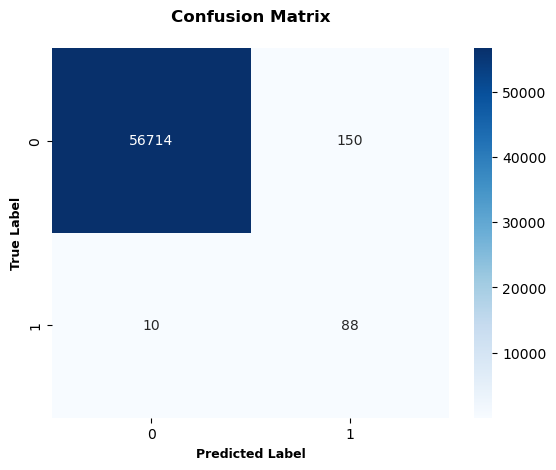

In [8]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontweight='bold', fontsize=12, y=1.05)
plt.xlabel('Predicted Label',fontweight='bold', fontsize=9)
plt.ylabel('True Label',fontweight='bold', fontsize=9)
plt.show()

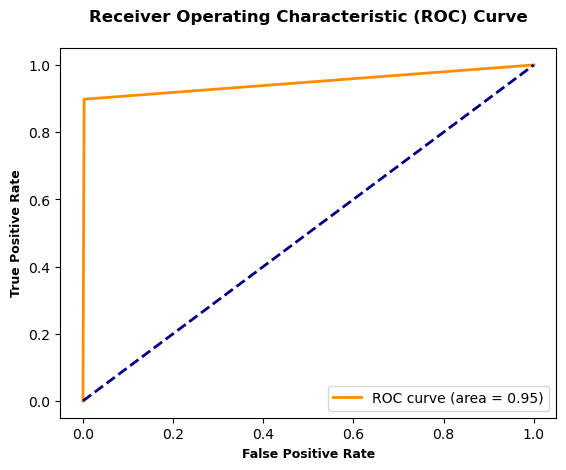

In [9]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate',fontweight='bold', fontsize=9)
plt.ylabel('True Positive Rate',fontweight='bold', fontsize=9)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold', fontsize=12, y=1.05)
plt.legend(loc="lower right")
plt.show()

# Visualize Training History

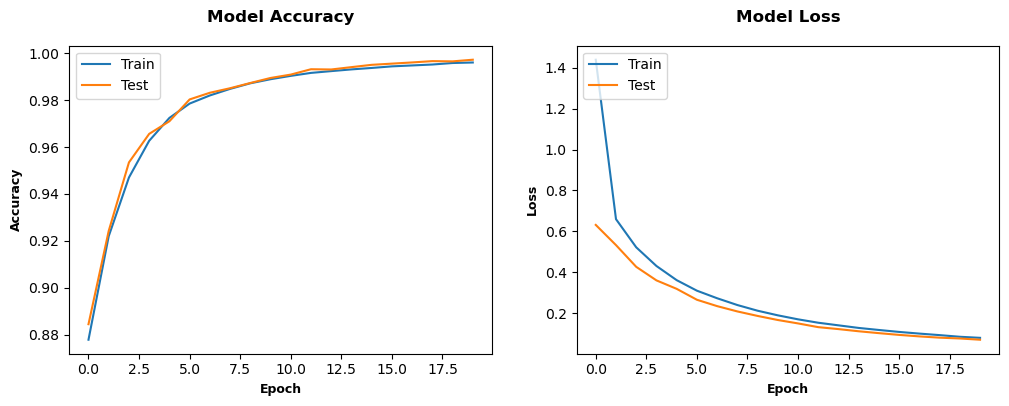

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontweight='bold', fontsize=12, y=1.05)
plt.ylabel('Accuracy',fontweight='bold', fontsize=9)
plt.xlabel('Epoch',fontweight='bold', fontsize=9)
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontweight='bold', fontsize=12, y=1.05)
plt.ylabel('Loss',fontweight='bold', fontsize=9)
plt.xlabel('Epoch',fontweight='bold', fontsize=9)
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()